# Long-form audio transcription using Hugging Face Transformers
Source: https://github.com/machinelearnear/long-audio-transcription-spanish

In [1]:
import time
from os.path import exists as path_exists
from pathlib import Path

In [2]:
if not path_exists('transcripts'):
    !mkdir transcripts

## Download audio from YouTube video

In [3]:
YouTubeID = 'gFFLJaQbLCM' 
OutputFile = 'test_audio_youtube.m4a'

In [4]:
if not path_exists(OutputFile):
    !youtube-dl -o $OutputFile $YouTubeID --extract-audio --restrict-filenames -f 'bestaudio[ext=m4a]'

## End to End Automatic Speech Recognition

In [5]:
model_name = "jonatasgrosman/wav2vec2-xls-r-1b-spanish"

In [6]:
def save_to_file(transcript, text=None):
    with open(f'transcripts/transcribed_speech_{text}.txt', "w") as f:
        f.write(transcript)

### Option A: Process long audio file directly with `Pipelines`

In [7]:
import librosa
from transformers import pipeline

/home/studio-lab-user/.conda/envs/machinelearnear-long-audio-transcription/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [8]:
pipe = pipeline(model=model_name)

Downloading:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

In [9]:
speech, sample_rate = librosa.load(OutputFile,sr=16000)

/home/studio-lab-user/.conda/envs/machinelearnear-long-audio-transcription/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [10]:
stime = time.time()
transcript = pipe(speech, chunk_length_s=10, stride_length_s=(4,2))
print(f'total time: {time.time()-stime:.2f} seconds')

total time: 1159.39 seconds


In [12]:
print(transcript['text'])
save_to_file(transcript['text'],text='hf_pipelines')

soy maría esperanza casuca soy andrés malamud y esto es agora un podcast de conversación política de el diario a holandrés cómo estás buen día buen día momentos creo que estás viajando sospeche exactamente hacia argentina cuando estemos en el aire voy a estar en la patria buenísimo bueno y de qué vamos a hablar esta semana salió el tema de los ex presidentes que podrían ser candidatos qué te parece vales toay que marcarlo en una cuestión legal en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos ex presidentes activos en política verdad exactamente te agrego irigoyen para que mi banda nos enoje por la omisión corroes exactamente así más allá de las reelecciones inmediatas que estaban permiti

### Option B: Split audio files in chunks by timestamp (`PyDub`)

In [13]:
import torch
import pydub
import array
import numpy as np
from pydub.utils import mediainfo
from pydub import AudioSegment
from pydub.utils import get_array_type

In [14]:
pydub_speech = pydub.AudioSegment.from_file(OutputFile)

In [15]:
pydub_speech[:15*1000] # miliseconds

In [16]:
def audio_resampler(sound, sample_rate=16000):
    sound = sound.set_frame_rate(sample_rate)
    left = sound.split_to_mono()[0]
    bit_depth = left.sample_width * 8
    array_type = pydub.utils.get_array_type(bit_depth)
    numeric_array = np.array(array.array(array_type, left._data))
    
    return np.asarray(numeric_array,dtype=np.double), sample_rate

In [17]:
speech, sample_rate = audio_resampler(pydub_speech)

In [18]:
transcript = ''
for chunk in np.array_split(speech,len(speech)/sample_rate/30)[:2]: # split every 30 seconds
    output = pipe(chunk)
    transcript = transcript + ' ' + output['text']
    print(output)
    
transcript = transcript.strip()

{'text': 'soy maría esperanza caso soy andrés malamud y esto es ahora un podcast de conversación política de el diario aholandrés cómo estás buen día buen día comandaos creo que estás viajando sospechosactamente hacia argentina cuando estamos en el aire voy a estar en la patria buenísimo bueno y de qué vamos a hablar esta semana salió el tema de los ex presidentes que podrían ser candidatos qué te parece vale esque'}
{'text': 'have marcarlo en una cuestión legal en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos ex presidentes activos en política verdad'}


In [19]:
print(transcript)
save_to_file(transcript,text='pydub_timestamps')

soy maría esperanza caso soy andrés malamud y esto es ahora un podcast de conversación política de el diario aholandrés cómo estás buen día buen día comandaos creo que estás viajando sospechosactamente hacia argentina cuando estamos en el aire voy a estar en la patria buenísimo bueno y de qué vamos a hablar esta semana salió el tema de los ex presidentes que podrían ser candidatos qué te parece vale esque have marcarlo en una cuestión legal en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos ex presidentes activos en política verdad


### Option C: Split audio files based on silence detection (`Librosa`/`PyDub`)

(1) `Librosa`

In [20]:
import librosa
from librosa import display

import matplotlib.pyplot as plt

In [21]:
speech, sample_rate = librosa.load(OutputFile,sr=16000)

/home/studio-lab-user/.conda/envs/machinelearnear-long-audio-transcription/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


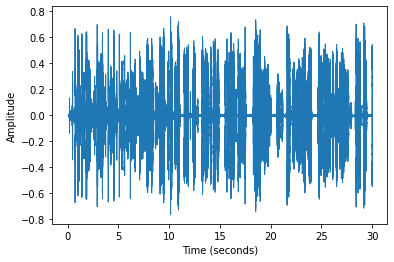

In [22]:
plt.figure()
librosa.display.waveshow(y=speech[:30*sample_rate], sr=sample_rate) # first 30 seconds
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

In [23]:
non_mute_sections_in_speech = librosa.effects.split(speech,top_db=50)

In [24]:
transcript = ''
for chunk in non_mute_sections_in_speech[:6]:
    speech_chunk = speech[chunk[0]:chunk[1]]
    output = pipe(speech_chunk)
    transcript = transcript + ' ' + output['text']
    print(output)
    
transcript = transcript.strip()

{'text': 'soy maría esperanza casula soy andrés malamud y esto es agora un podcast de conversación política de el diario a holandrés cómo estás buen día buen día me comandaos creo que estás viajando'}
{'text': 'sospeche exactamente hacia argentina'}
{'text': 'cuando estemos en el aire voy a estar en la patria buenísimo'}
{'text': 'bueno y de qué vamos a la esta semana salió el tema de los ex presidentes que podrían ser candidatos'}
{'text': 'qué te parece vale estoy que enmarcarlo en una cuestión legal en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos expresidentes activos en política verdad exactamente te agrego irigoyen para que mi banda nos enoje por la comisión corroes exactamente así

In [25]:
print(transcript)
save_to_file(transcript,text='librosa_silence')

soy maría esperanza casula soy andrés malamud y esto es agora un podcast de conversación política de el diario a holandrés cómo estás buen día buen día me comandaos creo que estás viajando sospeche exactamente hacia argentina cuando estemos en el aire voy a estar en la patria buenísimo bueno y de qué vamos a la esta semana salió el tema de los ex presidentes que podrían ser candidatos qué te parece vale estoy que enmarcarlo en una cuestión legal en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos expresidentes activos en política verdad exactamente te agrego irigoyen para que mi banda nos enoje por la comisión corroes exactamente así más allá de las reelecciones inmediatas que estaban permi

(2) `PyDub`

In [26]:
pydub_speech = pydub.AudioSegment.from_file(OutputFile)

In [27]:
chunks = pydub.silence.split_on_silence(
    pydub_speech,
    min_silence_len = 500,
    silence_thresh = pydub_speech.dBFS - 16,
    keep_silence = 250, # optional
)

# minimum chunk length
target_length = 20 * 1000 # 20 seconds

output_chunks = [chunks[0]]
for chunk in chunks[1:]:
    if len(output_chunks[-1]) < target_length:
        output_chunks[-1] += chunk
    else:
        # if the last output chunk
        # is longer than the target length,
        # we can start a new one
        output_chunks.append(chunk)

In [28]:
output_chunks[0]

In [29]:
transcript = ''
for chunk in output_chunks[:6]:
    speech_chunk, sample_rate = audio_resampler(chunk)
    output = pipe(speech_chunk)
    transcript = transcript + ' ' + output['text']
    print(output)
    
transcript = transcript.strip()

{'text': 'soy maría esperanza caso soy andrés malamud y esto es ahora un podcast de conversación política de el diario aholandrés cómo estás buen día buen día me comandaos creo que estás viajando sospecha exactamente hacia argentina cuando estemos en el aire voy a estar en la patria buenísimo bueno y de qué vamos holaestasemana'}
{'text': 'salió el tema de los ex presidentes que podrían ser candidatos qué te parece vale esto ay que marcarlo en una cuestión legal o sea en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos'}
{'text': 'julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos expresidentes activos en política exactamente te agrego irigosiom para que mi banda nos enojepor la comisión rrosectamente así más allá de las reelecciones inmedi

In [30]:
print(transcript)
save_to_file(transcript,text='pydub_silence')

soy maría esperanza caso soy andrés malamud y esto es ahora un podcast de conversación política de el diario aholandrés cómo estás buen día buen día me comandaos creo que estás viajando sospecha exactamente hacia argentina cuando estemos en el aire voy a estar en la patria buenísimo bueno y de qué vamos holaestasemana salió el tema de los ex presidentes que podrían ser candidatos qué te parece vale esto ay que marcarlo en una cuestión legal o sea en el sentido de que en argentina se da la característica de que los ex presidentes legalmente pueden volver a ser presidentes y hay no sé si un montón pero hay varios casos históricos empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos expresidentes activos en política exactamente te agrego irigosiom para que mi banda nos enojepor la comisión rrosectamente así más allá de las reelecciones inmediatas que estaban permitidas en los

## Compare results

In [50]:
from youtube_transcript_api import YouTubeTranscriptApi
transcript = YouTubeTranscriptApi.get_transcript(YouTubeID,languages=['es'])
transcript_from_YouTube = ' '.join([i['text'] for i in transcript])
save_to_file(transcript_from_YouTube,text='generated_by_youtube')

In [51]:
from utils import *
from IPython.display import HTML, display

In [52]:
base = "transcripts/transcribed_speech_hf_pipelines.txt"
# compare = "transcripts/transcribed_speech_pydub_timestamps.txt"
# compare = "transcripts/transcribed_speech_pydub_silence.txt"
# compare = "transcripts/transcribed_speech_librosa_silence.txt"
compare = "transcripts/transcribed_speech_generated_by_youtube.txt"

In [54]:
a = open(base,'r').readlines()[0][:1000]
b = open(compare,'r').readlines()[0][:1000]
print(f'Original: {base} / Compare: {compare}')
display(HTML(html_diffs(a,b)))

Original: transcripts/transcribed_speech_hf_pipelines.txt / Compare: transcripts/transcribed_speech_generated_by_youtube.txt


## References

- [Making automatic speech recognition work on large files with Wav2Vec2 in Transformers](https://huggingface.co/blog/asr-chunking)
- [Boosting Wav2Vec2 with n-grams in Transformers](https://huggingface.co/blog/wav2vec2-with-ngram)
- https://huggingface.co/jonatasgrosman/wav2vec2-xls-r-1b-spanish
- https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-spanish
- https://huggingface.co/spaces/speech-recognition-community-v2/FinalLeaderboard

In [43]:
!pip install youtube-transcript-api

In [49]:
FinalTranscript

'soy maría esperanza que asume el sueño en rima la mud y estoy segura podcast e conversación política de el diario hola andrés cómo estás buen día buen día me cómo andamos creo que estás viajando exactamente hacia argentina cuando tenemos en el aire voy a estar en la patria buenísimo bueno y de que vamos a dar esta semana salió el tema de los expresidentes que podrían ser candidatos qué te parece dale es que hay que enmarcarlo en una cuestión legal no o sean en el sentido de que en argentina se da la característica de que los expresidentes legalmente pueden volver a estar presidentes y hay un montón no sé si un montón pero hay varios casos históricos que empezando por los más famosos julio argentino roca domingo perón lo que sí creo que es novedoso es que en este momento actual se da la circunstancia de que tenemos dos ex presidentes activos en política verdad exactamente te agrego yrigoyen para que mi banda no se enoje por la omisión corre es exactamente así más allá de las revisiones

### Option D: Stream audio using `Librosa`

In [ ]:
# import nltk
# nltk.download('punkt')

# def correct_sentence(input_text):
#     sentences = nltk.sent_tokenize(input_text)
#     return (' '.join([s.replace(s[0],s[0].capitalize(),1) for s in sentences]))

# def asr_transcript(tokenizer, model, input_file):
#     transcript = ""
#     # Ensure that the sample rate is 16k
#     print(librosa.get_samplerate(input_file))

#     # Stream over 30 seconds chunks rather than load the full file
#     stream = librosa.stream(
#         input_file,
#         block_length=30,
#         frame_length=16000,
#         hop_length=16000
#     )

#     for speech in stream:
#         if len(speech.shape) > 1:
#             speech = speech[:, 0] + speech[:, 1]

#         input_values = tokenizer(speech, return_tensors="pt").input_values
#         logits = model(input_values).logits

#         predicted_ids = torch.argmax(logits, dim=-1)
#         transcription = tokenizer.decode(predicted_ids[0])
#         transcript += correct_sentence(transcription.lower())

#     return transcript